In [1]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.decomposition import PCA


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

The object of this notebook is to utilize the Allen Human Brain Atlas RNAseq data extracted from the human middle temporal gyrus in order to identify specific cell-types. The cell-types are available with the dataset, identified by *Hodge et al., 2018 BioRxiv*. This information will be fed into CiberSortX, which will create a signature matrix, and can subsequently identify the fraction of cell types in a separate bulk microarray sample like the one we're working with in the other notebooks.

RNAseq data:https://celltypes.brain-map.org/rnaseq

CiberSortX:https://cibersortx.stanford.edu/tutorial.php

We will then try a different cell-type expression pipeline inspired by Seidletz et al. 2019 *BioRxiv*, using a reference sample provided by Lake et al., 2018 *Nature Biotechnology*.

In [4]:
# If you want to save figure to disk, input the directory you want to save figures to here:

fig_dir = '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NCRevisions/'

# CiberSort Approach
A word of caution -- some of these spreadsheets are ENORMOUS and will cause your computer to explode by loading them.

Partially due to the size of the datasets, partially due to constraints of CiberSortX and partially due to validation, we run the CiberSortX approach four separate times, and compare the results across runs

#### Load data

In [3]:
csort_dir = '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/RNAseq/human/MTG/'
samps = pandas.read_csv(os.path.join(csort_dir,'human_MTG_2018-06-14_samples-columns.csv'))
ex = pandas.read_csv(os.path.join(csort_dir,'human_MTG_2018-06-14_exon-matrix.csv'))
genes = pandas.read_csv(os.path.join(csort_dir,'human_MTG_2018-06-14_genes-rows.csv'))

In [5]:
# enter your git directory here
git_dir = '/home/users/jvogel/git/Hippocampus_AP_Axis/'
wdir = os.path.join(git_dir, 'Data')

df = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info.csv'))
xp = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_gxp.csv'),index_col=0)

In [6]:
# Enter the path for the directory where you stored your file downloads
aba_dir = '/data1/users/jvogel/Brainspan/'

probes = pandas.read_csv(os.path.join(aba_dir,'lmd_matrix_12566/rows_metadata.csv'))

#### Harmonize data

In [4]:
ex.index = genes.gene.values
shared_genes = [x for x in range(probes.shape[0]) if probes.loc[x,'gene_symbol'] in ex.index]
csort_mixture = xp.loc[shared_genes]
csort_mixture.index = [x for x in probes.gene_symbol if x in ex.index]

csort_mixture.drop('Unnamed: 0',axis=1,inplace=True)
ex.drop('Unnamed: 0',axis=1, inplace=True)
#ex.columns = samps.cluster

#### Reduce file size
Cibersort can only take files up to 500 mb. This works out anyway because we want to validate the consistency of the method. We will run four different samples of 4000k cells each, stratified by cell type

In [5]:
# Randomly subsample
from sklearn.model_selection import train_test_split

bigsamp, smallsamp = train_test_split(samps,test_size = 0.25, random_state=123, shuffle=True, stratify=samps.cluster)

In [6]:
# Randomly subsample again for validation
bigsamp2, smallsamp2 = train_test_split(bigsamp,test_size = 0.33, random_state=123, 
                                        shuffle=True, stratify=bigsamp.cluster)

In [34]:
# Randomly subsample again for a third validation
# The remaining samples will be the fourth validation
smallsamp4, smallsamp3 = train_test_split(bigsamp2,test_size = 0.5, random_state=123, 
                                        shuffle=True, stratify=bigsamp2.cluster)

#### Save data

In [74]:
for n,samp in dict(zip(range(1:5),[smallsamp,smallsamp2,
                                        smallsamp3, smallsamp4]
                           )):
    print('working on sample', n)
    cex = pandas.DataFrame(ex[ex.columns[samp.index]], copy=True)
    cex.columns = [x.replace(' ','_') for x in samp.cluster.values]
    cex.to_csv(os.path.join(csort_dir,'ref_sample_small%s.txt'%n), sep='\t')
print('saving mixture file')
csort_mixture.to_csv(os.path.join('mixture.txt'),sep='\t')

Next you would have to go to the CiberSortX website, create signature matrices, and then run the Cell Fractionation step. This can take quite a long time for each of the four subsamples -- I was mostly running the Cell Fraction part overnight. Here is the order of operations:

* First, upload ref_sample_smallN.txt


STEP 1. Create Signature Matrix


* Custom
* scRNA-Seq
* Reference Sample Input --> ref_sample_smallN.txt
* Quartile normalization disabled
* All other settings in their default (as of August 19, 2019)
* Run it
* Save CiberSort outputs, delete ref_sample from CiberSort


* Next, Upload mixture.txt


STEP 2. Impute Cell Fractions


* Custom
* Signature matrix input --> Output from previous step
* Mixture file input --> mixture.txt
* Enable batch correction
* Enable quantile normalization (since it's microarray data now)
* All other settings on defaults
* Run it
* Save output
* Delete everything and start again for the next session


To prevent you from necessarily having to go through all of that in order to run this code, and for the sake of full reproducibility, the output is available in the git repo

# Review Results of Cibersort

In [6]:
cells = pandas.read_csv(os.path.join(wdir,'CIBERSORTx_fractions_1.csv'))
cells2 = pandas.read_csv(os.path.join(wdir,'CIBERSORTx_fractions_2.csv'))
cells3 = pandas.read_csv(os.path.join(wdir,'CIBERSORTx_fractions_3.csv'))
cells4 = pandas.read_csv(os.path.join(wdir,'CIBERSORTx_fractions_4.csv'))

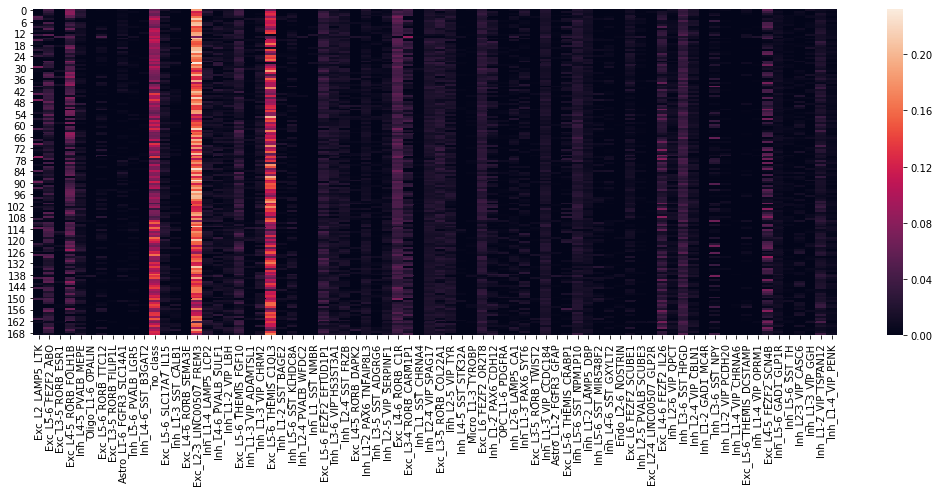

In [7]:
plt.subplots(figsize=(18,6))
sns.heatmap(cells4[cells4.columns[1:-3]])

#### Eliminate unstable cell types
Getting rid of cell types that have an average correlation across subsamples < r=0.7

In [8]:
keepers_lib = []
keepers_cons = []
for col in cells.columns[1:-2]:
    mat = np.concatenate([cells[col].values.reshape(-1,1),
                          cells2[col].values.reshape(-1,1),
                          cells3[col].values.reshape(-1,1),
                          cells4[col].values.reshape(-1,1)], 
                         axis=1)
    avg_frac = mat.mean()
    cmat = np.corrcoef(mat.T)
    avg_corr = cmat[np.tril_indices_from(cmat,k=-1)].mean()
    std_corr = cmat[np.tril_indices_from(cmat,k=-1)].std()
    #print(col,avg_corr)
    #print(cmat,'\n')
    if avg_corr>0.7:
        keepers_lib.append(col)
        if avg_frac < 0.01:
            keepers_cons.append(col)

#### Find the mean across the four subsamples

In [9]:
avg_cells = pandas.DataFrame(index = cells.index, columns = cells.columns[1:-2])
for cell in cells.columns[1:-2]:
    mat = np.concatenate([cells[cell].values.reshape(-1,1),
                          cells2[cell].values.reshape(-1,1),
                          cells3[cell].values.reshape(-1,1),
                          cells4[col].values.reshape(-1,1)], 
                         axis=1)
    avg_cells.loc[:,cell] = mat.mean(1)

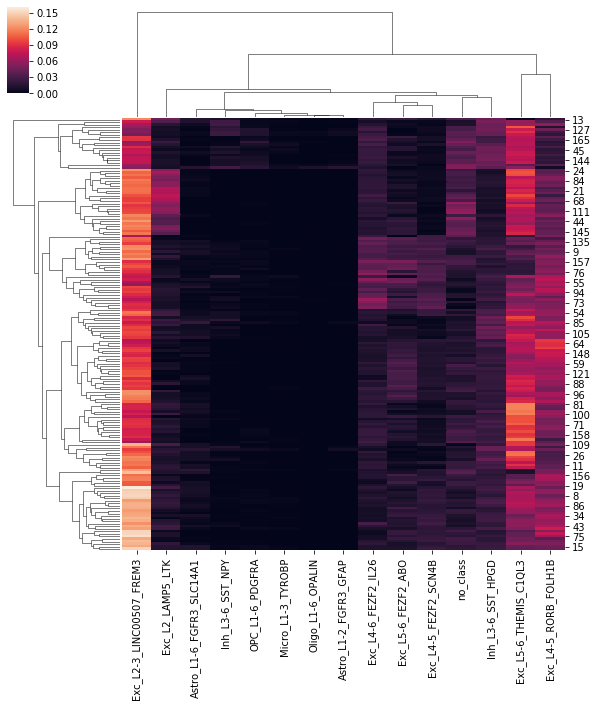

In [10]:
#plt.subplots(figsize=(18,6))
sns.clustermap(avg_cells[keepers_lib])

#### Take a quick look at distributions by subfield, and by position along axis

In [13]:
df.loc[:,'id_match'] = ['%s_%s'%(df.loc[x,'donor'],df.loc[x,'sample']) for x in df.index]
all(cells.Mixture.values == df.id_match.values)

True

In [15]:
cells.loc[:,'subfield'] = df.structure_acronym.values
cells.loc[:,'position'] = df.position_along_hipp_AP_axis.values

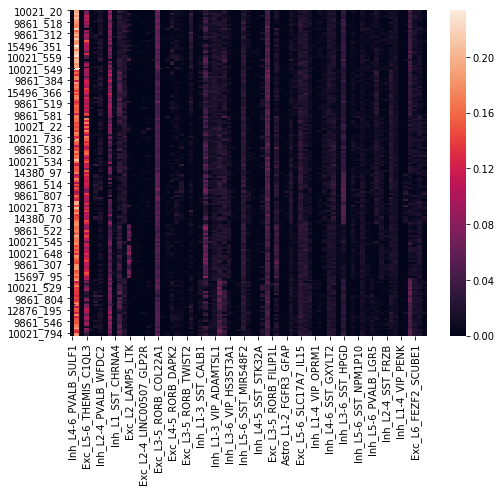

In [16]:
plt.subplots(figsize=(8,6))
cells.index = cells.Mixture.values
sns.heatmap(cells.sort_values('subfield')[cells.columns[1:-5]])

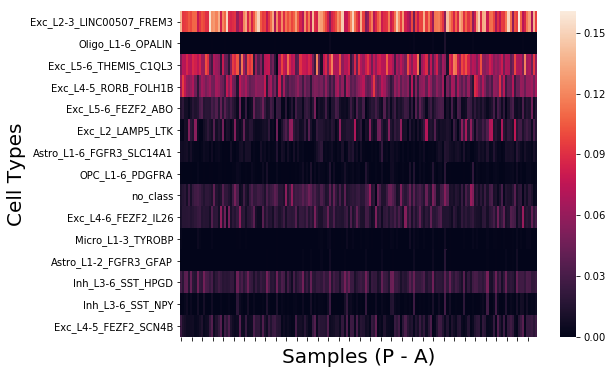

In [295]:
# plot all the cells across axis position, make it a bit nicer for the manuscript
plt.subplots(figsize=(8,6))
cells.index = cells.Mixture.values
g = sns.heatmap(avg_cells.sort_values('position')[keepers_lib].T)
g.set_xticklabels(['' for x in g.get_xticklabels()])
g.set_xlabel('Samples (P - A)',fontdict={'size':20})
g.set_ylabel('Cell Types',fontdict={'size':20})
g.get_figure().savefig(os.path.join('CT_CS_Heatmap.pdf'),bbox_inches='tight')

#### look at statistical associations with position

In [18]:
r_position = pandas.DataFrame(index = keepers_lib)

for i,tbl in enumerate([cells, cells2, cells3, cells4, avg_cells]):
    tbl.loc[:,'subfield'] = df.structure_acronym.values
    tbl.loc[:,'position'] = df.position_along_hipp_AP_axis.values
    if i == 4:
        nm = 'avg'
    else:
        nm = i+1
    for cell in r_position.index:
        r,p = stats.pearsonr(tbl[cell].values, tbl.position.values)
        r_position.loc[cell,'r_%s'%nm] = r
        r_position.loc[cell,'r2_%s'%nm] = r**2
        r_position.loc[cell,'p_%s'%nm] = p
    r_position.loc[:,'fdr_%s'%nm] = multipletests(r_position['p_%s'%nm],
                                                  method='fdr_bh')[1]

In [19]:
r_position.sort_values('r2_avg',ascending=False).head(12)

,r_1,r2_1,p_1,fdr_1,r_2,r2_2,p_2,fdr_2,r_3,r2_3,p_3,fdr_3,r_4,r2_4,p_4,fdr_4,r_avg,r2_avg,p_avg,fdr_avg
Exc_L2_LAMP5_LTK,0.115113,0.013251,0.134970,0.289221,0.144633,0.020919,0.059866,0.224496,0.261267,0.068261,0.000579,0.008682,0.129843,0.016859,0.091487,0.228718,0.190342,0.036230,0.012911,0.096863
Micro_L1-3_TYROBP,0.178815,0.031975,0.019643,0.098217,0.185919,0.034566,0.015207,0.172541,0.184532,0.034052,0.015997,0.119981,0.160668,0.025814,0.036348,0.149194,0.186170,0.034659,0.015068,0.096863
Astro_L1-6_FGFR3_SLC14A1,0.212681,0.045233,0.005361,0.040208,0.174306,0.030383,0.023006,0.172541,0.139724,0.019523,0.069176,0.207529,0.208919,0.043647,0.006255,0.093823,0.179206,0.032115,0.019373,0.096863
Inh_L3-6_SST_NPY,0.138659,0.019226,0.071345,0.214035,0.150053,0.022516,0.050809,0.224496,0.146545,0.021475,0.056530,0.207529,0.157861,0.024920,0.039785,0.149194,0.147585,0.021781,0.054782,0.201073
Astro_L1-2_FGFR3_GFAP,0.126140,0.015911,0.101197,0.252992,0.126046,0.015888,0.101453,0.286819,0.144060,0.020753,0.060897,0.207529,0.135589,0.018384,0.077904,0.228718,0.134812,0.018174,0.079641,0.201073
OPC_L1-6_PDGFRA,0.159698,0.025504,0.037505,0.140646,0.115442,0.013327,0.133849,0.286819,0.119615,0.014308,0.120264,0.300659,0.171903,0.029551,0.024992,0.149194,0.134463,0.018080,0.080429,0.201073
no_class,-0.233152,0.054360,0.002215,0.033224,-0.006157,0.000038,0.936489,0.936489,-0.077570,0.006017,0.314682,0.590029,-0.102971,0.010603,0.181476,0.388877,-0.115488,0.013338,0.133693,0.286484
Oligo_L1-6_OPALIN,0.075640,0.005721,0.326911,0.490366,0.096494,0.009311,0.210653,0.353100,0.091262,0.008329,0.236571,0.506939,0.087459,0.007649,0.256757,0.481419,0.089615,0.008031,0.245170,0.459694
Exc_L5-6_FEZF2_ABO,-0.090268,0.008148,0.241737,0.424557,-0.121006,0.014642,0.115982,0.286819,0.007795,0.000061,0.919643,0.919643,-0.068433,0.004683,0.375235,0.562852,-0.069288,0.004801,0.369285,0.615474
Exc_L5-6_THEMIS_C1QL3,0.087831,0.007714,0.254734,0.424557,0.052580,0.002765,0.495886,0.644949,0.026469,0.000701,0.731878,0.844475,0.061685,0.003805,0.424233,0.578500,0.059906,0.003589,0.437744,0.652770


In [298]:
# store results
r_position.to_csv(os.path.join(fig_dir,'CT_CS_R_position.csv'))

Exc_L2_LAMP5_LTK
p_1        0.134970
p_2        0.059866
p_3        0.000579
p_4        0.091487
fdr_avg    0.096863
Name: Exc_L2_LAMP5_LTK, dtype: float64


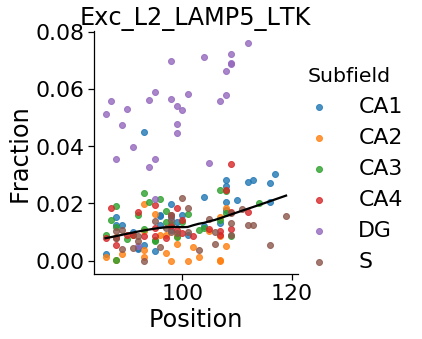

Astro_L1-6_FGFR3_SLC14A1
p_1        0.005361
p_2        0.023006
p_3        0.069176
p_4        0.006255
fdr_avg    0.096863
Name: Astro_L1-6_FGFR3_SLC14A1, dtype: float64


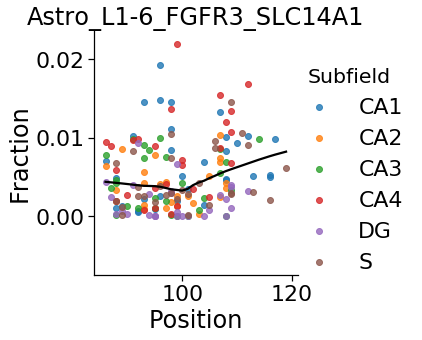

Micro_L1-3_TYROBP
p_1        0.019643
p_2        0.015207
p_3        0.015997
p_4        0.036348
fdr_avg    0.096863
Name: Micro_L1-3_TYROBP, dtype: float64


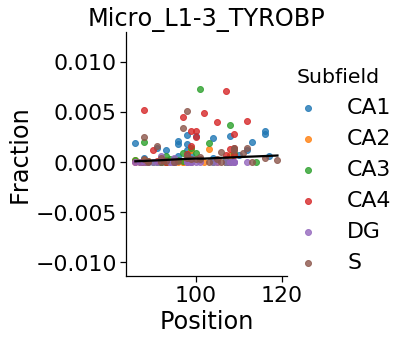

In [302]:
# plot results for cell-types surviving avg Q<0.1
sns.set_context('notebook',font_scale=2)
for cell in r_position.index:
    if r_position.loc[cell,'fdr_avg'] <0.1:
        print(cell)
        print(r_position.loc[cell,['p_1','p_2','p_3','p_4','fdr_avg']])
        plotr = pandas.concat([pandas.Series(cells.position.values),
                               pandas.Series(avg_cells[cell].values),
                               pandas.Series(cells.subfield.values)],
                             axis=1)
        plotr.columns = ['Position','Fraction','Subfield']
        fig = sns.lmplot(x='Position',y='Fraction',hue='Subfield', data=plotr, fit_reg=False)
        sns.regplot(x=cells.position.values, y=avg_cells[cell].values, lowess=True, 
                    marker='', color='black')
        #plt.ylim(-0.003,0.08)
        plt.title(cell)
#         plt.savefig(os.path.join(fig_dir,'CT_CS_Assoc_%s.pdf'%cell[:3]),
#                    bbox_inches='tight')
        plt.show()


#### What about subfield

In [303]:
f_subfield = pandas.DataFrame(index = keepers_lib)

for i,tbl in enumerate([cells, cells2, cells3, avg_cells]):
    if i == 3:
        nm = 'avg'
    else:
        nm = i+1
    for cell in f_subfield.index:
        F,p = stats.f_oneway(tbl[tbl.subfield=='CA1'][cell].values,
                            tbl[tbl.subfield=='CA2'][cell].values,
                            tbl[tbl.subfield=='CA3'][cell].values,
                            tbl[tbl.subfield=='CA4'][cell].values,
                            tbl[tbl.subfield=='S'][cell].values,
                            tbl[tbl.subfield=='DG'][cell].values)
        f_subfield.loc[cell,'F_%s'%nm] = F
        f_subfield.loc[cell,'p_%s'%nm] = p
    f_subfield.loc[:,'fdr_%s'%nm] = multipletests(f_subfield['p_%s'%nm],
                                                  method='Bonferroni')[1]

In [304]:
f_subfield.sort_values('F_avg',ascending=False).head(12)

,F_1,p_1,fdr_1,F_2,p_2,fdr_2,F_3,p_3,fdr_3,F_avg,p_avg,fdr_avg
Exc_L4-5_FEZF2_SCN4B,152.699918,8.498312e-60,1.274747e-58,253.311578,3.502517e-75,5.253775e-74,109.808026,1.781814e-50,2.672721e-49,303.128666,6.922293e-81,1.038344e-79
Inh_L3-6_SST_HPGD,104.844255,3.203022e-49,4.804533e-48,91.263242,1.522829e-45,2.284243e-44,78.903545,7.832543e-42,1.174881e-40,118.807657,1.210061e-52,1.815091e-51
Exc_L2_LAMP5_LTK,115.497183,7.329549e-52,1.099432e-50,74.002647,3.015346e-40,4.523018e-39,37.825338,1.106234e-25,1.659351e-24,91.337725,1.450158e-45,2.175236e-44
Exc_L4-6_FEZF2_IL26,68.586895,2.075954e-38,3.113931e-37,62.198379,4.112339e-36,6.168509e-35,74.380629,2.262170e-40,3.393255e-39,79.012917,7.232884e-42,1.084933e-40
Exc_L2-3_LINC00507_FREM3,18.887637,8.291344e-15,1.243702e-13,52.967332,1.648446e-32,2.472669e-31,52.379477,2.879171e-32,4.318757e-31,48.516364,1.238394e-30,1.857591e-29
Exc_L5-6_THEMIS_C1QL3,23.918559,5.027554e-18,7.541331e-17,47.783130,2.579250e-30,3.868875e-29,38.800055,3.657557e-26,5.486336e-25,43.323659,2.586517e-28,3.879775e-27
Inh_L3-6_SST_NPY,37.524734,1.560926e-25,2.341390e-24,43.224341,2.874599e-28,4.311898e-27,38.697659,4.105681e-26,6.158522e-25,41.873573,1.225165e-27,1.837747e-26
Exc_L5-6_FEZF2_ABO,30.860557,4.762434e-22,7.143651e-21,24.162058,3.568596e-18,5.352894e-17,40.577041,5.047346e-27,7.571019e-26,36.843322,3.424998e-25,5.137497e-24
Exc_L4-5_RORB_FOLH1B,20.633294,5.896040e-16,8.844060e-15,11.744612,1.024888e-09,1.537333e-08,17.013755,1.552977e-13,2.329466e-12,18.714437,1.082600e-14,1.623900e-13
no_class,13.882785,2.606884e-11,3.910327e-10,17.525294,6.910888e-14,1.036633e-12,12.079028,5.716633e-10,8.574949e-09,16.579739,3.105012e-13,4.657518e-12


In [305]:
f_subfield.to_csv(os.path.join(fig_dir,'CT_CS_F_subfield.csv'))

Exc_L2-3_LINC00507_FREM3
fdr_avg    1.857591e-29
Name: Exc_L2-3_LINC00507_FREM3, dtype: float64


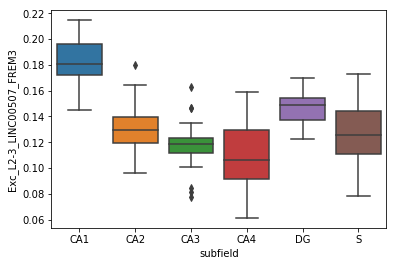

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 CA1    CA2   -0.0397  -0.0571 -0.0223  True 
 CA1    CA3   -0.0413  -0.0582 -0.0244  True 
 CA1    CA4   -0.0477  -0.0648 -0.0307  True 
 CA1     DG   -0.0299  -0.0467  -0.013  True 
 CA1     S    -0.0449  -0.0615 -0.0283  True 
 CA2    CA3   -0.0016  -0.0195  0.0164 False 
 CA2    CA4    -0.008  -0.0261  0.0101 False 
 CA2     DG    0.0099  -0.0081  0.0278 False 
 CA2     S    -0.0051  -0.0228  0.0125 False 
 CA3    CA4   -0.0064   -0.024  0.0112 False 
 CA3     DG    0.0115   -0.006  0.0289 False 
 CA3     S    -0.0036  -0.0207  0.0136 False 
 CA4     DG    0.0179   0.0003  0.0355  True 
 CA4     S     0.0028  -0.0145  0.0201 False 
  DG     S     -0.015  -0.0322  0.0021 False 
---------------------------------------------
Exc_L5-6_THEMIS_C1QL3
fdr_avg    3.879775e-27
Name: Exc_L5-6_THEMIS_C1QL3, dtype: float64


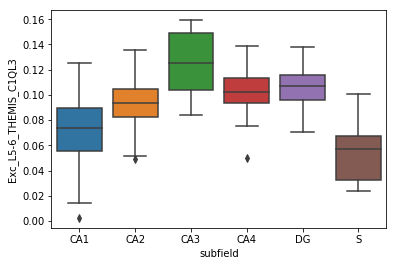

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 CA1    CA2    0.0245   0.0031  0.0459  True 
 CA1    CA3    0.0553   0.0345  0.076   True 
 CA1    CA4    0.0311   0.0102  0.052   True 
 CA1     DG    0.0334   0.0127  0.0541  True 
 CA1     S    -0.0145  -0.0349  0.0058 False 
 CA2    CA3    0.0308   0.0087  0.0528  True 
 CA2    CA4    0.0066  -0.0156  0.0288 False 
 CA2     DG    0.0089  -0.0131  0.0309 False 
 CA2     S     -0.039  -0.0607 -0.0173  True 
 CA3    CA4   -0.0242  -0.0458 -0.0026  True 
 CA3     DG   -0.0219  -0.0433 -0.0005  True 
 CA3     S    -0.0698  -0.0908 -0.0488  True 
 CA4     DG    0.0023  -0.0193  0.0239 False 
 CA4     S    -0.0456  -0.0669 -0.0244  True 
  DG     S    -0.0479   -0.069 -0.0269  True 
---------------------------------------------
Exc_L4-5_RORB_FOLH1B
fdr_avg    1.623900e-13
Name: Exc_L4-5_RORB_FOLH1B, dtype: float64


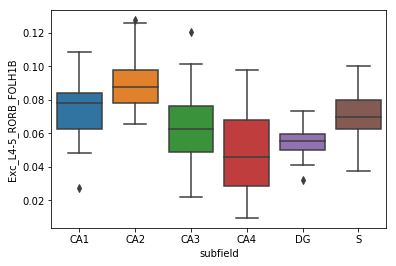

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 CA1    CA2    0.0179   0.0041  0.0318  True 
 CA1    CA3    -0.011  -0.0244  0.0025 False 
 CA1    CA4   -0.0264  -0.0399 -0.0128  True 
 CA1     DG   -0.0172  -0.0306 -0.0037  True 
 CA1     S     0.0035  -0.0097  0.0167 False 
 CA2    CA3   -0.0289  -0.0432 -0.0146  True 
 CA2    CA4   -0.0443  -0.0587 -0.0299  True 
 CA2     DG   -0.0351  -0.0494 -0.0208  True 
 CA2     S    -0.0144  -0.0285 -0.0004  True 
 CA3    CA4   -0.0154  -0.0294 -0.0014  True 
 CA3     DG   -0.0062  -0.0201  0.0077 False 
 CA3     S     0.0144   0.0008  0.0281  True 
 CA4     DG    0.0092  -0.0049  0.0232 False 
 CA4     S     0.0298   0.0161  0.0436  True 
  DG     S     0.0207   0.007   0.0343  True 
---------------------------------------------
Exc_L5-6_FEZF2_ABO
fdr_avg    5.137497e-24
Name: Exc_L5-6_FEZF2_ABO, dtype: float64


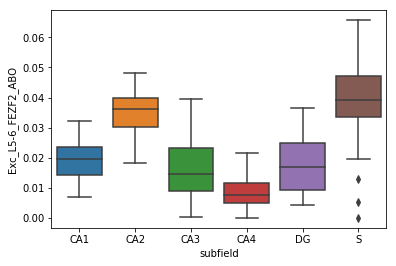

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 CA1    CA2    0.0215   0.0131  0.0298  True 
 CA1    CA3    0.0019  -0.0062   0.01  False 
 CA1    CA4   -0.0079  -0.0161  0.0003 False 
 CA1     DG    0.0071   -0.001  0.0152 False 
 CA1     S     0.0195   0.0115  0.0274  True 
 CA2    CA3   -0.0195  -0.0282 -0.0109  True 
 CA2    CA4   -0.0294  -0.0381 -0.0207  True 
 CA2     DG   -0.0143   -0.023 -0.0057  True 
 CA2     S     -0.002  -0.0105  0.0065 False 
 CA3    CA4   -0.0099  -0.0183 -0.0014  True 
 CA3     DG    0.0052  -0.0032  0.0136 False 
 CA3     S     0.0176   0.0093  0.0258  True 
 CA4     DG    0.0151   0.0066  0.0235  True 
 CA4     S     0.0274   0.0191  0.0357  True 
  DG     S     0.0124   0.0041  0.0206  True 
---------------------------------------------
Exc_L2_LAMP5_LTK
fdr_avg    2.175236e-44
Name: Exc_L2_LAMP5_LTK, dtype: float64


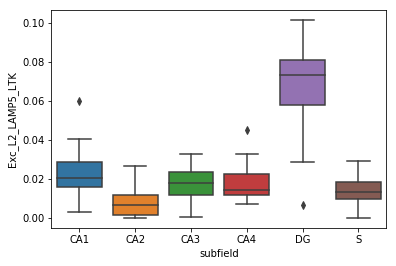

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 CA1    CA2   -0.0077  -0.0158  0.0004 False 
 CA1    CA3   -0.0063  -0.0141  0.0016 False 
 CA1    CA4   -0.0072  -0.0152  0.0007 False 
 CA1     DG    0.0461   0.0382  0.0539  True 
 CA1     S    -0.0086  -0.0164 -0.0009  True 
 CA2    CA3    0.0015  -0.0069  0.0098 False 
 CA2    CA4    0.0005  -0.0079  0.009  False 
 CA2     DG    0.0538   0.0454  0.0621  True 
 CA2     S    -0.0009  -0.0091  0.0073 False 
 CA3    CA4   -0.0009  -0.0091  0.0073 False 
 CA3     DG    0.0523   0.0442  0.0605  True 
 CA3     S    -0.0024  -0.0104  0.0056 False 
 CA4     DG    0.0533   0.045   0.0615  True 
 CA4     S    -0.0014  -0.0095  0.0067 False 
  DG     S    -0.0547  -0.0627 -0.0467  True 
---------------------------------------------
Astro_L1-6_FGFR3_SLC14A1
fdr_avg    0.000026
Name: Astro_L1-6_FGFR3_SLC14A1, dtype: float64


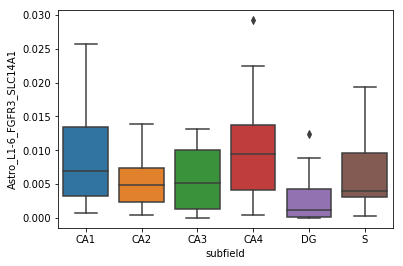

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 CA1    CA2   -0.0041  -0.0082  0.0001 False 
 CA1    CA3   -0.0035  -0.0076  0.0005 False 
 CA1    CA4    0.0017  -0.0024  0.0057 False 
 CA1     DG   -0.0066  -0.0106 -0.0026  True 
 CA1     S    -0.0027  -0.0067  0.0012 False 
 CA2    CA3    0.0005  -0.0038  0.0048 False 
 CA2    CA4    0.0057   0.0014   0.01   True 
 CA2     DG   -0.0025  -0.0068  0.0018 False 
 CA2     S     0.0013  -0.0029  0.0055 False 
 CA3    CA4    0.0052   0.001   0.0094  True 
 CA3     DG    -0.003  -0.0072  0.0011 False 
 CA3     S     0.0008  -0.0033  0.0049 False 
 CA4     DG   -0.0082  -0.0124 -0.0041  True 
 CA4     S    -0.0044  -0.0085 -0.0003  True 
  DG     S     0.0038  -0.0002  0.0079 False 
---------------------------------------------
OPC_L1-6_PDGFRA
fdr_avg    9.062860e-10
Name: OPC_L1-6_PDGFRA, dtype: float64


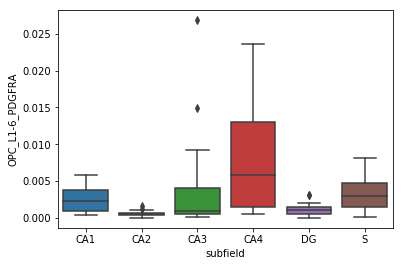

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 CA1    CA2    -0.003  -0.0063  0.0004 False 
 CA1    CA3    0.0004  -0.0028  0.0037 False 
 CA1    CA4    0.0061   0.0029  0.0094  True 
 CA1     DG    -0.002  -0.0053  0.0012 False 
 CA1     S     0.0005  -0.0027  0.0036 False 
 CA2    CA3    0.0034  -0.0001  0.0068 False 
 CA2    CA4    0.0091   0.0056  0.0126  True 
 CA2     DG    0.0009  -0.0025  0.0044 False 
 CA2     S     0.0034    0.0    0.0068  True 
 CA3    CA4    0.0057   0.0023  0.0091  True 
 CA3     DG   -0.0025  -0.0058  0.0009 False 
 CA3     S      0.0    -0.0033  0.0033 False 
 CA4     DG   -0.0082  -0.0116 -0.0048  True 
 CA4     S    -0.0057   -0.009 -0.0023  True 
  DG     S     0.0025  -0.0008  0.0058 False 
---------------------------------------------
no_class
fdr_avg    4.657518e-12
Name: no_class, dtype: float64


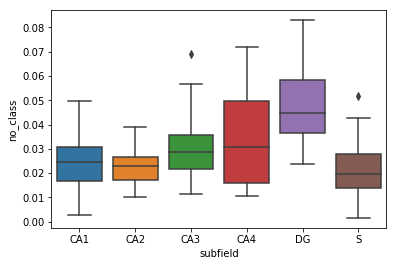

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 CA1    CA2    0.0011  -0.0102  0.0123 False 
 CA1    CA3    0.0059   -0.005  0.0169 False 
 CA1    CA4    0.0049  -0.0061  0.016  False 
 CA1     DG    0.0238   0.0129  0.0348  True 
 CA1     S    -0.0063  -0.0171  0.0044 False 
 CA2    CA3    0.0049  -0.0068  0.0165 False 
 CA2    CA4    0.0039  -0.0078  0.0156 False 
 CA2     DG    0.0228   0.0111  0.0344  True 
 CA2     S    -0.0074  -0.0188  0.0041 False 
 CA3    CA4    -0.001  -0.0124  0.0104 False 
 CA3     DG    0.0179   0.0066  0.0292  True 
 CA3     S    -0.0123  -0.0234 -0.0011  True 
 CA4     DG    0.0189   0.0074  0.0303  True 
 CA4     S    -0.0113  -0.0225 -0.0001  True 
  DG     S    -0.0301  -0.0413  -0.019  True 
---------------------------------------------
Exc_L4-6_FEZF2_IL26
fdr_avg    1.084933e-40
Name: Exc_L4-6_FEZF2_IL26, dtype: float64


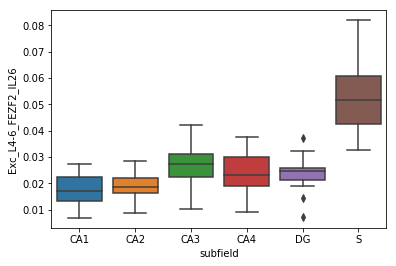

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
 CA1    CA2   -0.0007  -0.0071 0.0057 False 
 CA1    CA3    0.0082   0.002  0.0144  True 
 CA1    CA4    0.0051  -0.0011 0.0114 False 
 CA1     DG    0.0052   -0.001 0.0115 False 
 CA1     S     0.0335   0.0274 0.0396  True 
 CA2    CA3    0.0089   0.0023 0.0155  True 
 CA2    CA4    0.0058  -0.0008 0.0125 False 
 CA2     DG    0.006   -0.0007 0.0126 False 
 CA2     S     0.0342   0.0277 0.0407  True 
 CA3    CA4   -0.0031  -0.0096 0.0034 False 
 CA3     DG    -0.003  -0.0094 0.0034 False 
 CA3     S     0.0253   0.019  0.0316  True 
 CA4     DG    0.0001  -0.0064 0.0066 False 
 CA4     S     0.0284   0.022  0.0347  True 
  DG     S     0.0283   0.022  0.0346  True 
--------------------------------------------
Micro_L1-3_TYROBP
fdr_avg    0.000011
Name: Micro_L1-3_TYROBP, dtype: float64


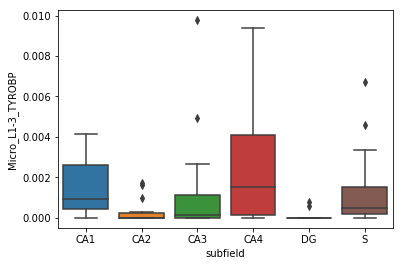

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 CA1    CA2   -0.0013  -0.0027  0.0001 False 
 CA1    CA3   -0.0003  -0.0017  0.001  False 
 CA1    CA4    0.001   -0.0003  0.0024 False 
 CA1     DG   -0.0015  -0.0028 -0.0001  True 
 CA1     S    -0.0005  -0.0018  0.0008 False 
 CA2    CA3    0.001   -0.0004  0.0024 False 
 CA2    CA4    0.0024   0.0009  0.0038  True 
 CA2     DG   -0.0002  -0.0016  0.0013 False 
 CA2     S     0.0008  -0.0006  0.0022 False 
 CA3    CA4    0.0013  -0.0001  0.0027 False 
 CA3     DG   -0.0012  -0.0026  0.0002 False 
 CA3     S    -0.0002  -0.0016  0.0012 False 
 CA4     DG   -0.0025  -0.0039 -0.0011  True 
 CA4     S    -0.0015  -0.0029 -0.0002  True 
  DG     S     0.001   -0.0004  0.0023 False 
---------------------------------------------
Astro_L1-2_FGFR3_GFAP
fdr_avg    6.064214e-09
Name: Astro_L1-2_FGFR3_GFAP, dtype: float64


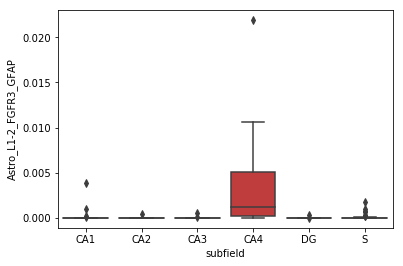

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 CA1    CA2   -0.0002  -0.0017  0.0014 False 
 CA1    CA3   -0.0001  -0.0016  0.0013 False 
 CA1    CA4    0.003    0.0015  0.0045  True 
 CA1     DG   -0.0001  -0.0016  0.0013 False 
 CA1     S     0.0001  -0.0013  0.0016 False 
 CA2    CA3     0.0    -0.0015  0.0016 False 
 CA2    CA4    0.0031   0.0016  0.0047  True 
 CA2     DG     0.0    -0.0015  0.0016 False 
 CA2     S     0.0003  -0.0013  0.0018 False 
 CA3    CA4    0.0031   0.0016  0.0047  True 
 CA3     DG     0.0    -0.0015  0.0015 False 
 CA3     S     0.0003  -0.0012  0.0017 False 
 CA4     DG   -0.0031  -0.0046 -0.0016  True 
 CA4     S    -0.0029  -0.0044 -0.0014  True 
  DG     S     0.0002  -0.0012  0.0017 False 
---------------------------------------------
Inh_L3-6_SST_HPGD
fdr_avg    1.815091e-51
Name: Inh_L3-6_SST_HPGD, dtype: float64


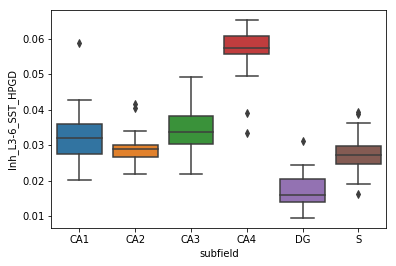

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 CA1    CA2   -0.0058  -0.0105 -0.0011  True 
 CA1    CA3   -0.0006  -0.0052  0.004  False 
 CA1    CA4    0.0184   0.0138  0.023   True 
 CA1     DG   -0.0186  -0.0232 -0.0141  True 
 CA1     S    -0.0047  -0.0092 -0.0002  True 
 CA2    CA3    0.0052   0.0003   0.01   True 
 CA2    CA4    0.0242   0.0193  0.0291  True 
 CA2     DG   -0.0129  -0.0177  -0.008  True 
 CA2     S     0.001   -0.0038  0.0058 False 
 CA3    CA4    0.019    0.0143  0.0238  True 
 CA3     DG    -0.018  -0.0227 -0.0133  True 
 CA3     S    -0.0041  -0.0088  0.0005 False 
 CA4     DG   -0.0371  -0.0418 -0.0323  True 
 CA4     S    -0.0232  -0.0279 -0.0185  True 
  DG     S     0.0139   0.0092  0.0185  True 
---------------------------------------------
Inh_L3-6_SST_NPY
fdr_avg    1.837747e-26
Name: Inh_L3-6_SST_NPY, dtype: float64


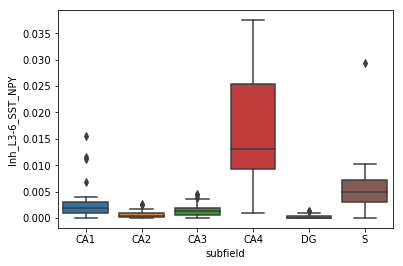

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 CA1    CA2   -0.0015  -0.0045  0.0015 False 
 CA1    CA3   -0.0009  -0.0038  0.002  False 
 CA1    CA4    0.0104   0.0075  0.0134  True 
 CA1     DG   -0.0017  -0.0046  0.0012 False 
 CA1     S     0.0015  -0.0014  0.0043 False 
 CA2    CA3    0.0006  -0.0026  0.0037 False 
 CA2    CA4    0.0119   0.0088  0.015   True 
 CA2     DG   -0.0002  -0.0033  0.0029 False 
 CA2     S     0.0029  -0.0001  0.006  False 
 CA3    CA4    0.0114   0.0083  0.0144  True 
 CA3     DG   -0.0008  -0.0038  0.0023 False 
 CA3     S     0.0024  -0.0006  0.0054 False 
 CA4     DG   -0.0121  -0.0152 -0.0091  True 
 CA4     S     -0.009   -0.012  -0.006  True 
  DG     S     0.0032   0.0002  0.0061  True 
---------------------------------------------
Exc_L4-5_FEZF2_SCN4B
fdr_avg    1.038344e-79
Name: Exc_L4-5_FEZF2_SCN4B, dtype: float64


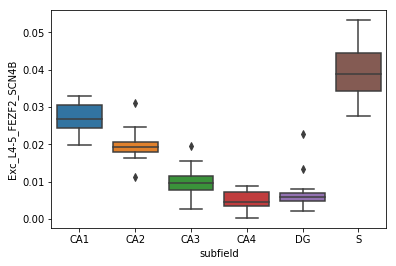

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 CA1    CA2    -0.008  -0.0133 -0.0026  True 
 CA1    CA3   -0.0214  -0.0265 -0.0162  True 
 CA1    CA4    -0.028  -0.0332 -0.0228  True 
 CA1     DG   -0.0247  -0.0299 -0.0195  True 
 CA1     S     0.0126   0.0075  0.0177  True 
 CA2    CA3   -0.0134  -0.0189 -0.0079  True 
 CA2    CA4    -0.02   -0.0256 -0.0145  True 
 CA2     DG   -0.0167  -0.0222 -0.0112  True 
 CA2     S     0.0206   0.0152  0.026   True 
 CA3    CA4   -0.0067  -0.0121 -0.0012  True 
 CA3     DG   -0.0033  -0.0087  0.002  False 
 CA3     S     0.034    0.0287  0.0392  True 
 CA4     DG    0.0033  -0.0021  0.0087 False 
 CA4     S     0.0406   0.0353  0.046   True 
  DG     S     0.0373   0.032   0.0426  True 
---------------------------------------------


In [116]:
for cell in f_subfield.index:
    if f_subfield.loc[cell,'fdr_avg'] <0.1:
        print(cell)
        print(f_subfield.loc[cell,['fdr_avg']])
        sns.boxplot(x='subfield', y=cell, data = avg_cells)
        plt.show()
        print(pairwise_tukeyhsd(cells[cell], avg_cells.subfield.values))

# Seidlitz inspired

This is an approach borrowed by a sweet paper on BioRxiv by Seidletz et al. https://doi.org/10.1101/573279, which can work using a simpler reference dataset (i.e. a list of genes for each cell type). The idea is to find the wighted mean expression of genes associated with specific cell type, where the values are weighted by PCA.

I don't know how licensing of supplementary files works, so I'll just let you go ahead and download Supplementary Table 1 from Lake 2018 *Nature Biotechnology*.  doi: 10.1038/nbt.4038

Just stick the path to that file in the next cell and the rest should be fine

In [7]:
lake_fl = '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/RNAseq/Lake2018_S1.xlsx'

In [8]:
lake = pandas.ExcelFile(lake_fl).parse('Table S3')
lake.drop(lake.columns[8:],axis=1,inplace=True)
lake.columns = lake.loc[lake.index[2],:].values
lake.drop(lake.index[:3],axis=0,inplace=True)
lake.index = range(len(lake))
lake.head()

,nan,Gene,p Value,False Discovery Rate,Average Difference (log fold change),Fraction of Detection in Cluster,Fraction of Detection in Other Clusters,Cluster
0,NaN,CBLN2,0,0,1.73427,0.705,0.107,Ex1
1,NaN,ENC1,0,0,1.5074,0.697,0.153,Ex1
2,NaN,AC011288.2,0,0,1.25959,0.594,0.15,Ex1
3,NaN,TESPA1,0,0,1.22353,0.518,0.088,Ex1
4,NaN,RP11-314P15.2,0,0,1.18018,0.346,0.035,Ex1


In [11]:
## Get cell-type expression

# I tried using a couple approaches for getting the "weighted mean", including a straight
# up weighted mean, a dot product, and just straight up the results of the PCA. It turns
# out that the values differed but they're all totally collinear.

# If some of the code below this doesn't work, you'll have to change the [0: in lines
# 15, 25 and 26 in this cell to [1:
# This is caused by a dumb indexing discrepancy. Specifically you should do this if you 
# get the following error two cells down:
# ValueError: Must have equal len keys and value when setting with an iterable

szPCA = {}
ctypes = ['Lake_%s'%x for x in lake.Cluster.unique()]

for nm in ['wtMn','Dot','PCA','Raw']:
    # initalize results
    szPCA.update({nm: pandas.DataFrame(index = ctypes, columns = xp.columns[0:])})
    
# for each cell
for cell in lake.Cluster.unique():
    ctype = 'Lake_%s'%cell # get cell name
    genes = lake[lake.Cluster==cell]['Gene'].values # get cell-associated genes
    g_ids = probes[probes.gene_symbol.isin(genes)].index # and IDs
    g_names = probes[probes.gene_symbol.isin(genes)].gene_symbol # and names
    gdf = pandas.concat([xp.loc[g_ids], g_names],axis=1) # get expression of those genes
    ndf = pandas.DataFrame(index = gdf.gene_symbol.unique(), columns = gdf.columns[0:-1]) 
    # for each of those genes, average the expression values
    for gene in ndf.index:
        xs = gdf[gdf.gene_symbol==gene][gdf.columns[0:-1]] 
        ndf.loc[gene,:] = xs.mean(0).values
    
    # construct a PCA with the genes of this cell type
    pcamod = PCA(n_components=1,random_state=123).fit(ndf.T)
    # get the weights
    comp_weights = pcamod.explained_variance_ratio_
    weights = pcamod.components_
    pcatfm = pcamod.fit_transform(ndf.T)
    # get the various weighted mean measurements
    szPCA['wtMn'].loc[ctype,:] = (ndf.T * pcamod.components_[0,:]).mean(1)
    szPCA['PCA'].loc[ctype,:] = pcamod.fit_transform(ndf.T)[:,0]
    szPCA['Dot'].loc[ctype,:] = np.dot(ndf.T, pcamod.components_[0,:])
    szPCA['Raw'].loc[ctype,:] = ndf.T.mean(1).values
        
    print('finished',ctype)

finished Lake_Ex1
finished Lake_Ex2
finished Lake_Ex3a
finished Lake_Ex3b
finished Lake_Ex3c
finished Lake_Ex3d
finished Lake_Ex3e
finished Lake_Ex4
finished Lake_Ex5a
finished Lake_Ex5b
finished Lake_Ex6a
finished Lake_Ex6b
finished Lake_Ex8
finished Lake_Gran
finished Lake_In1a
finished Lake_In1b
finished Lake_In1c
finished Lake_In2
finished Lake_In3
finished Lake_In4a
finished Lake_In4b
finished Lake_In6a
finished Lake_In6b
finished Lake_In7
finished Lake_In8
finished Lake_Purk1
finished Lake_Purk2
finished Lake_End
finished Lake_Per
finished Lake_Ast
finished Lake_Ast_Cer
finished Lake_Oli
finished Lake_OPC
finished Lake_OPC_Cer
finished Lake_Mic


In [253]:
# Just curious if our top 100 genes are among these markers as the reviewer suggested...
# needs NB3 to be run
mod_genes = pandas.read_csv(os.path.join(wdir,'MAIN_model_genes_of_importance.csv'),
                           index_col=0)
lake[lake.Gene.isin(mod_genes[mod_genes.step==1]['gene_symbol'].values)].sort_values('Gene')

,nan,Gene,p Value,False Discovery Rate,Average Difference (log fold change),Fraction of Detection in Cluster,Fraction of Detection in Other Clusters,Cluster
308,NaN,COL5A2,2.1519e-70,7.16056e-70,1.25543,0.39,0.051,Ex2
534,NaN,COL5A2,8.25751e-91,3.4636e-90,1.07382,0.318,0.049,Ex3a
5093,NaN,COL5A2,5.07709e-73,1.74263e-72,1.44354,0.389,0.051,In4a
3601,NaN,DGKI,4.882e-33,9.45909e-33,0.629279,0.605,0.329,Ex8
2315,NaN,DGKI,1.33641e-93,5.74906e-93,0.363063,0.53,0.318,Ex4
445,NaN,DGKI,1.0638e-08,1.23944e-08,0.307417,0.5,0.331,Ex2
6986,NaN,DGKI,9.66438e-11,1.18272e-10,0.388748,0.503,0.33,Purk2
6590,NaN,DGKI,2.52359e-41,5.57067e-41,0.653632,0.546,0.328,Purk1
777,NaN,DGKI,3.11865e-17,4.51454e-17,0.258798,0.5,0.329,Ex3a
2993,NaN,DGKI,1.22582e-40,2.66868e-40,0.340273,0.518,0.325,Ex5b


In [12]:
table = 'Dot' # arbitrarily. Try PCA after the reuslts are similar
cells = pandas.DataFrame(szPCA[table], copy=True).T
cells.loc[:,'subfield'] = df.structure_acronym.values
cells.loc[:,'position'] = df.position_along_hipp_AP_axis.values

In [344]:
#cells.to_csv(os.path.join(wdir,'Lake_cells.csv'))

#### A bit of visualization

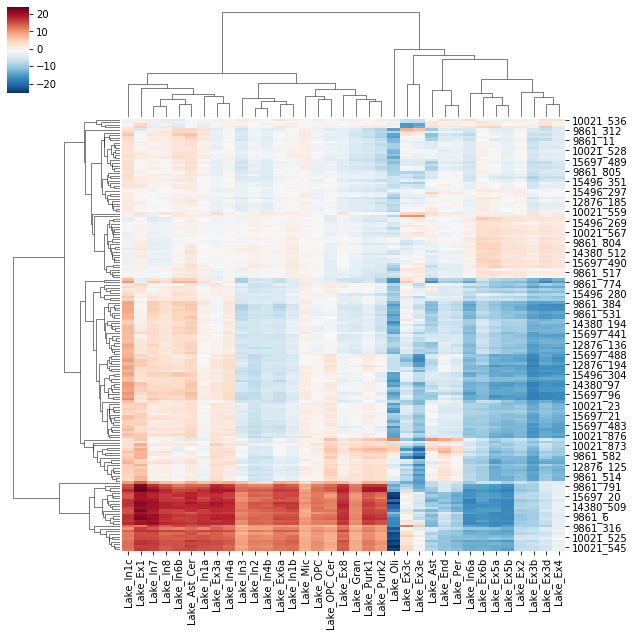

In [42]:
clusmap = sns.clustermap(cells[cells.columns[:-2]].astype(np.float64), cmap = 'RdBu_r')

Text(50.09375, 0.5, 'Cell Types')

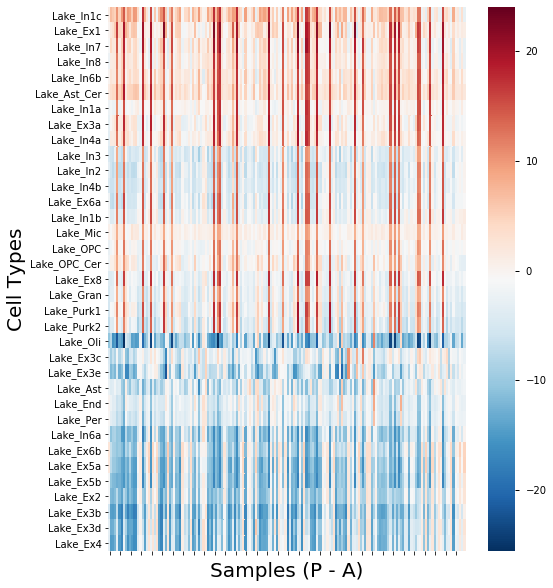

In [43]:
plt.subplots(figsize=(8,10))
sns.set_context('notebook',font_scale=1)
g = sns.heatmap(cells.sort_values('position')[clusmap.data2d.columns].astype(np.float64).T, cmap='RdBu_r')
g.set_xticklabels(['' for x in g.get_xticklabels()])
g.set_xlabel('Samples (P - A)',fontdict={'size':20})
g.set_ylabel('Cell Types',fontdict={'size':20})
# g.get_figure().savefig(os.path.join(wdir,'CT_SI_Heatmap.pdf'),
#                     bbox_inches='tight')

# Run the stats like we did for the CiberSort analysis

Here we're finding associations with axis position for each cell type and running multiple comparisons

In [45]:
r_position = pandas.DataFrame(index = cells.columns[:-2])

for cell in r_position.index:
    r,p = stats.pearsonr(cells[cell].values, cells.position.values)
    r_position.loc[cell,'r'] = r
    r_position.loc[cell,'r2'] = r**2
    r_position.loc[cell,'p'] = p
r_position.loc[:,'fdr'] = multipletests(r_position.p,method='fdr_bh')[1]

In [46]:
r_position.sort_values('fdr',ascending=True).head(10)

,r,r2,p,fdr
Lake_Ex2,0.242289,0.058704,0.001456,0.032436
Lake_Ex3e,0.237074,0.056204,0.001853,0.032436
Lake_Ex3c,0.225499,0.050850,0.003110,0.036286
Lake_Ex3b,0.210108,0.044145,0.005959,0.037647
Lake_Ex3d,0.208147,0.043325,0.006454,0.037647
Lake_Ex4,0.211804,0.044861,0.005559,0.037647
Lake_Ast,0.194219,0.037721,0.011154,0.055769
Lake_Ex6b,0.174430,0.030426,0.022907,0.073598
Lake_Ex5b,0.174150,0.030328,0.023131,0.073598
Lake_In6a,0.176502,0.031153,0.021311,0.073598


In [47]:
#r_position.to_csv(os.path.join(fig_dir,'CT_SI_R_position.csv'))

Lake_Ex2
p      0.001456
fdr    0.032436
Name: Lake_Ex2, dtype: float64


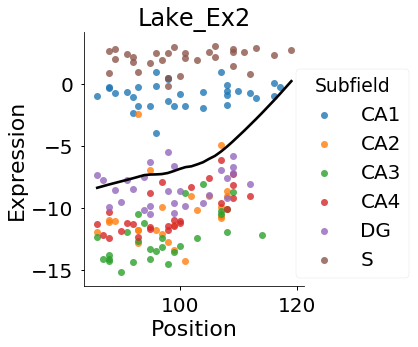

Lake_Ex3b
p      0.005959
fdr    0.037647
Name: Lake_Ex3b, dtype: float64


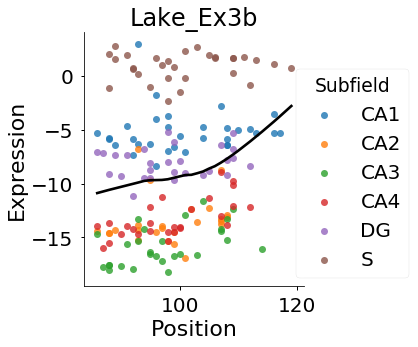

Lake_Ex3c
p      0.003110
fdr    0.036286
Name: Lake_Ex3c, dtype: float64


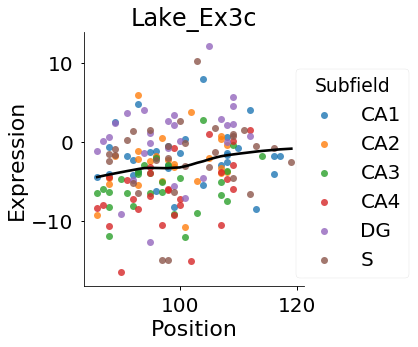

Lake_Ex3d
p      0.006454
fdr    0.037647
Name: Lake_Ex3d, dtype: float64


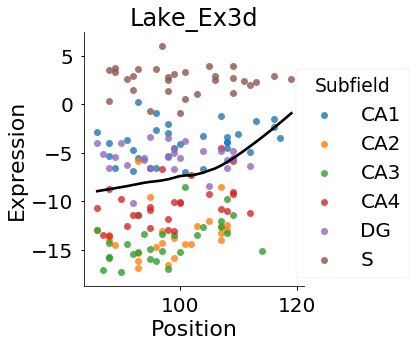

Lake_Ex3e
p      0.001853
fdr    0.032436
Name: Lake_Ex3e, dtype: float64


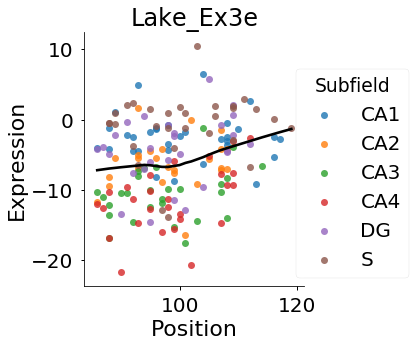

Lake_Ex4
p      0.005559
fdr    0.037647
Name: Lake_Ex4, dtype: float64


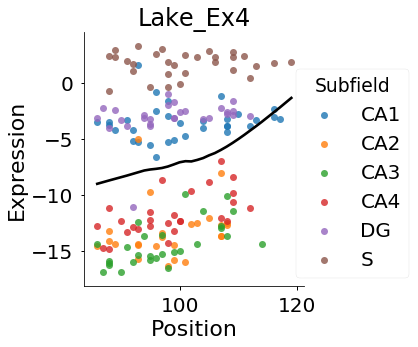

Lake_Ex5a
p      0.026770
fdr    0.078079
Name: Lake_Ex5a, dtype: float64


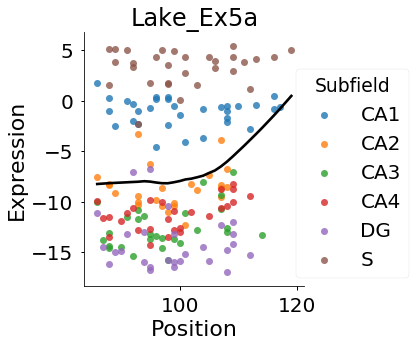

Lake_Ex5b
p      0.023131
fdr    0.073598
Name: Lake_Ex5b, dtype: float64


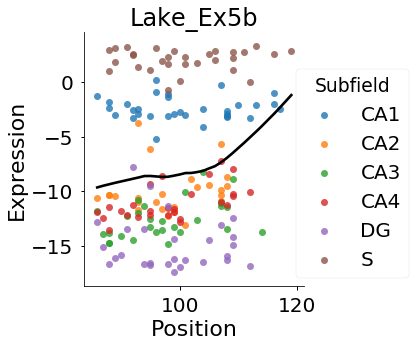

Lake_Ex6b
p      0.022907
fdr    0.073598
Name: Lake_Ex6b, dtype: float64


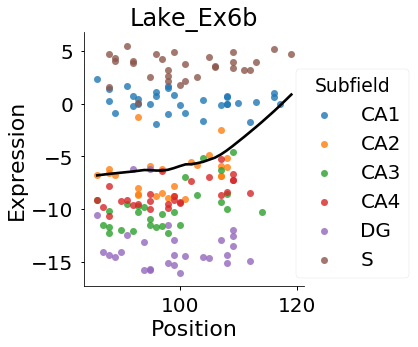

Lake_In1c
p      0.021894
fdr    0.073598
Name: Lake_In1c, dtype: float64


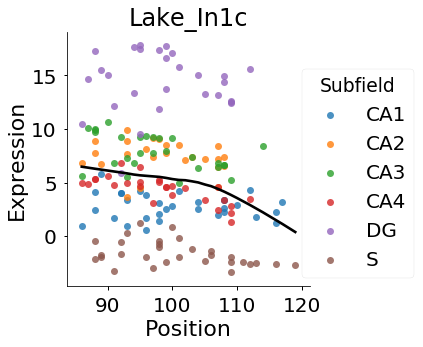

Lake_In6a
p      0.021311
fdr    0.073598
Name: Lake_In6a, dtype: float64


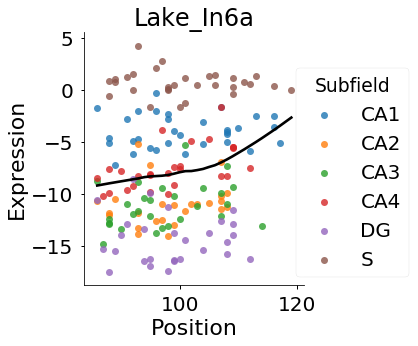

Lake_Ast
p      0.011154
fdr    0.055769
Name: Lake_Ast, dtype: float64


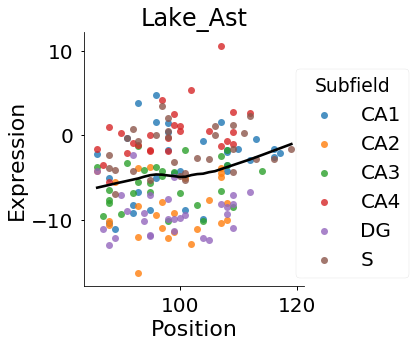

In [48]:
sns.set_context('notebook',font_scale=2)
for cell in r_position.index:
    if r_position.loc[cell,'fdr'] <0.1:
        print(cell)
        print(r_position.loc[cell,['p','fdr']])
        plotr = pandas.concat([pandas.Series(cells.position.values),
                               pandas.Series(cells[cell].values),
                               pandas.Series(cells.subfield.values)],
                             axis=1)
        plotr.columns = ['Position','Expression','Subfield']
        fig = sns.lmplot(x='Position',y='Expression',hue='Subfield', data=plotr, fit_reg=False)
        sns.regplot(x=cells.position.values, y=cells[cell].values, lowess=True, 
                    marker='', color='black')
        plt.title(cell)
#         plt.savefig(os.path.join(fig_dir,'CT_SI_Assoc_%s.pdf'%cell[-3:],
#                    bbox_inches='tight')

        plt.show()
    

In [16]:
f_subfield = pandas.DataFrame(index = cells.columns[:-2])

for cell in f_subfield.index:
    F,p = stats.f_oneway(cells[cells.subfield=='CA1'][cell].values,
                        cells[cells.subfield=='CA2'][cell].values,
                        cells[cells.subfield=='CA3'][cell].values,
                        cells[cells.subfield=='CA4'][cell].values,
                        cells[cells.subfield=='S'][cell].values,
                        cells[cells.subfield=='DG'][cell].values)
    f_subfield.loc[cell,'F'] = F
    f_subfield.loc[cell,'p'] = p
f_subfield.loc[:,'fdr'] = multipletests(f_subfield['p'],
                                              method='Bonferroni')[1]

In [19]:
f_subfield.to_csv(os.path.join(fig_dir,'CT_SI_F_subfield.csv'))